# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 852.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [24]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 186
The number of columns: 494


This block performs robust feature cleaning by:

1. Loading the full dataset from Excel.
2. Identifying and removing features with excessive outliers using the IQR method.
3. Winsorizing (capping) extreme values in the remaining features to reduce their influence.
4. Printing the new dataset dimensions and how many features were removed.

In [ ]:
# Imports
import pandas as pd

# Load the dataset from an Excel file into a DataFrame
df = pd.read_excel('FullDataset.xlsx')
print(f"Original shape: {df.shape}")  # Shows initial number of rows and columns (samples, features)

# Keep only the numeric columns (e.g., float, int) for outlier analysis
numeric_df = df.select_dtypes(include='number')

# Dictionary to store number of outliers found in each column
outlier_counts = {}

# Loop over all numeric features to detect outliers
for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)     # First quartile (25th percentile)
    Q3 = numeric_df[col].quantile(0.75)     # Third quartile (75th percentile)
    IQR = Q3 - Q1                           # Interquartile range
    lower_bound = Q1 - 5 * IQR              # Conservative lower outlier threshold
    upper_bound = Q3 + 5 * IQR              # Conservative upper outlier threshold

    # Identify outliers and count them
    outliers = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# Create a DataFrame from the dictionary to make it easy to sort/view
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outlier_count'])
outlier_df = outlier_df.sort_values(by='outlier_count', ascending=False)

# Define a threshold: if a feature has more than 17 outliers, we consider it too noisy
threshold = 17
features_to_drop = outlier_df[outlier_df['outlier_count'] > threshold].index.tolist()

# Drop those features from the original DataFrame
df = df.drop(columns=features_to_drop)

# Identify the features that are still allowed (with 17 or fewer outliers)
features_to_winsorize = outlier_df[outlier_df['outlier_count'] <= threshold].index.tolist()

# Apply outlier capping to these "acceptable" features
for feature in features_to_winsorize:
    if feature in df.columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 5 * IQR
        upper_bound = Q3 + 5 * IQR

        # Clip values that fall outside the acceptable range
        df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)

# Print new shape of the cleaned dataset
print(f"Shape after cleaning: {df.shape}")
print(f"Removed {len(features_to_drop)} features with more than {threshold} outliers.")

Original shape: (186, 494)
Shape after cleaning: (186, 487)
Removed 7 features with more than 17 outliers.


Checken voor normaal distributie

In [26]:
import pandas as pd
from scipy.stats import shapiro

# Keep only numeric features
numeric_df = df.select_dtypes(include='number')

# List to store names of normally distributed features
normally_distributed = []
not_normally_distributed = []
# Check normality using Shapiro-Wilk test
for col in numeric_df.columns:
    stat, p = shapiro(numeric_df[col])
    if p >= 0.05:
        normally_distributed.append(col)
    if p < 0.05:
        not_normally_distributed.append(col)

# Print the result
# print("Features with a normal distribution:")
# for feature in normally_distributed:
#    print(f"- {feature}")
# print("Features that are not normally distributed:")
# for feature in not_normally_distributed:
#    print(f"- {feature}")


c:\Users\ljwku\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Robust Scalar

In [27]:
from sklearn.preprocessing import RobustScaler

# Apply RobustScaler to the cleaned numeric columns
scaler = RobustScaler()

# Extract numeric columns again (post-cleaning & clipping)
numeric_df = df.select_dtypes(include='number')

# Fit and transform the data
scaled_data = scaler.fit_transform(numeric_df)

# Replace the original numeric columns in df with the scaled version
df[numeric_df.columns] = scaled_data

# Optional: print confirmation
print("Applied RobustScaler to numeric features.")


Applied RobustScaler to numeric features.


PCA Analysis and Visualization

This notebook performs Principal Component Analysis (PCA) to reduce dimensionality and visualize the 
structure of the dataset in 2D and 3D space. The data has been pre-cleaned and scaled.


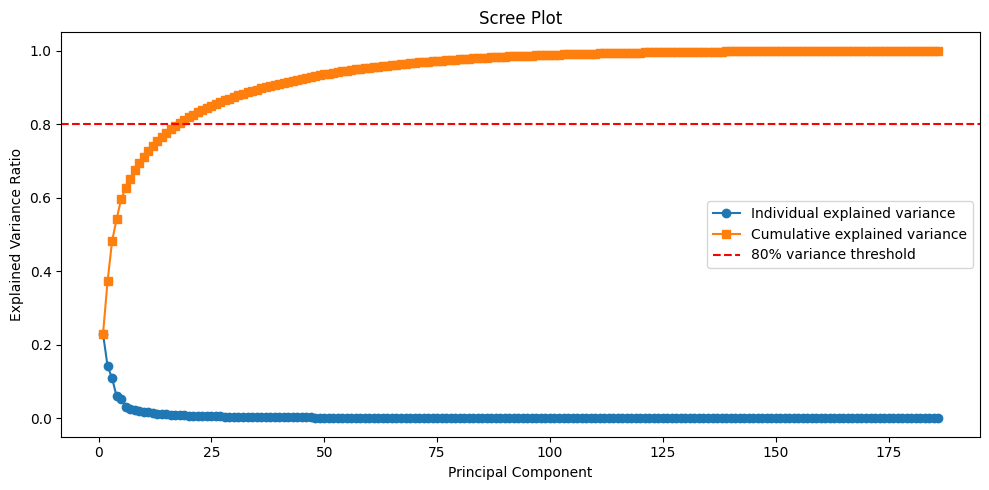

Number of components to retain 80% variance: 18


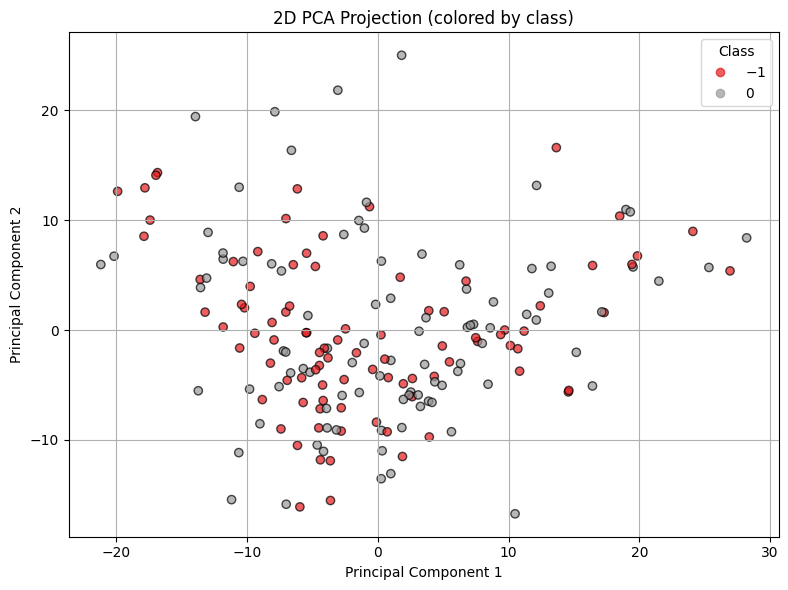

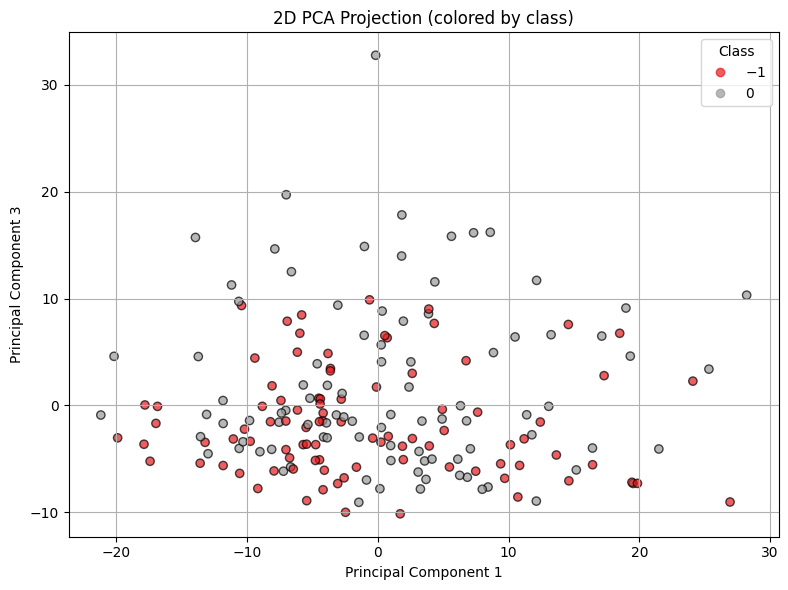

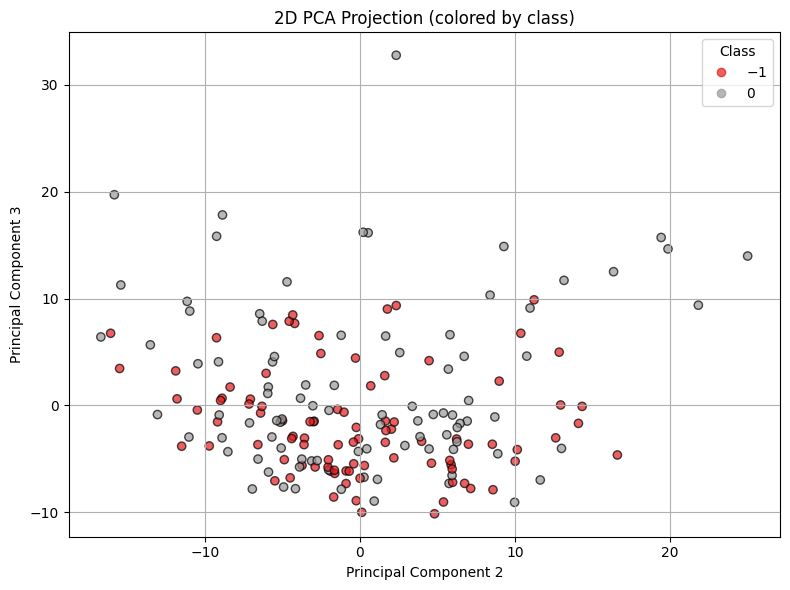

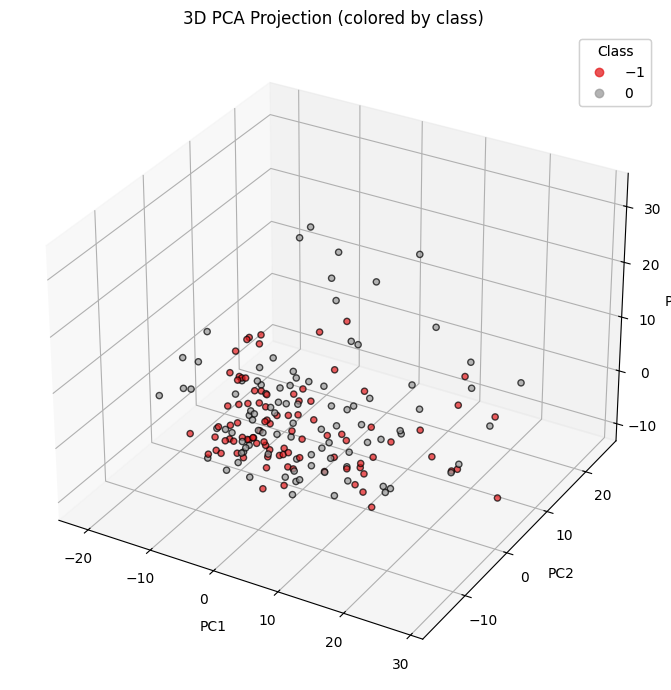

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Step 0: Define your class labels
y = df['label']  # 

# Step 1: Select numeric features
X = df.select_dtypes(include='number')

# Step 2: Run full PCA
pca = PCA()
X_pca_full = pca.fit_transform(X)

# Calculate explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Step 3: Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label='Individual explained variance')
plt.plot(range(1, len(explained_var)+1), cumulative_var, marker='s', label='Cumulative explained variance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance threshold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: Reduce to 80% variance
n_components = np.argmax(cumulative_var >= 0.80) + 1
print(f"Number of components to retain 80% variance: {n_components}")

# Project data to reduced PCA space
pca_reduced = PCA(n_components=n_components)
X_pca = pca_reduced.fit_transform(X)

# Step 5: 2D PCA plot (PC1 vs PC2), color by class
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Set1', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Projection (colored by class)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 2], c=y, cmap='Set1', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('2D PCA Projection (colored by class)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 1], X_pca[:, 2], c=y, cmap='Set1', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('2D PCA Projection (colored by class)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Class")
plt.tight_layout()
plt.show()

# Step 6: 3D PCA plot (PC1 vs PC2 vs PC3), color by class
if n_components >= 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    c=y, cmap='Set1', edgecolor='k', alpha=0.7)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D PCA Projection (colored by class)')
    
    # Add legend
    legend = ax.legend(*sc.legend_elements(), title="Class", loc="upper right")
    ax.add_artist(legend)
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough components for 3D plot.")


Feature selection

This function performs nested cross-validation for robust model evaluation and hyperparameter tuning using:
- Outer loop: Evaluates generalization performance
- Inner loop: Tunes hyperparameters using GridSearchCV
- RFECV: Performs recursive feature elimination within each outer fold

It returns performance scores, selected hyperparameters, and feature selection masks across multiple repeated trials

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

# difficult nested score to see best params. Perform grid-search with nested cross-validation for hyperparameter tuning

def nested_cross_validation(NUM_TRIALS : int, clf_class, param_grid : dict, X : np.ndarray, y : np.ndarray) -> tuple:
    """
    Perform nested cross-validation for hyperparameter tuning.

    Parameters:
    - NUM_TRIALS: Number of trials to run
    - pipeline: The machine learning pipeline to evaluate
    - param_grid: Hyperparameter grid for GridSearchCV
    - X: Feature matrix
    - y: Target vector

    Returns:
    - nested_scores: Array of scores from each trial
    - df_best_params: List of best parameters for each trial
    - df_masks: pandas dataframe of all masks
    """

    NUM_TRIALS = NUM_TRIALS
    
    nested_scores = np.zeros(NUM_TRIALS)      # To store average scores per trial
    all_best_params = []                      # To store best hyperparameters per trial
    all_feature_masks = []                    # To store feature selection masks per trial

    pipeline = Pipeline([
        ("scaler", MinMaxScaler()),  # Add a scaler to the pipeline
        ("clf_class", clf_class()),
    ])

    for i in range(NUM_TRIALS):
        # Outer and inner stratified cross-validation splitters
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i+1000)

        # Store the best parameters and scores for each outer fold
        best_params = []     # For storing best parameters for each outer fold
        outer_scores = []    # AUC scores per outer fold
        trial_masks = []     # Feature selection masks per outer fold


        for train_idx, test_idx in outer_cv.split(X, y):
            # Split data into training and test for this outer fold
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Feature selection via RFECV using the inner CV folds
            selector = RFECV(
                estimator=SVC(kernel='linear', probability=True),
                step=1,
                cv=inner_cv,
                scoring='roc_auc',
                n_jobs=-1)
                        
            # Fit the selector on the training data, not the entire dataset         
            selector.fit(X_train, y_train)  # Fit RFECV on outer training set
            trial_masks.append(selector.support_)  # Save which features were kept

            # Reduce training and test sets to selected features
            X_train = selector.transform(X_train)
            X_test = selector.transform(X_test)

            # Build a fresh pipeline for each fold
            pipeline = Pipeline([
                ("scaler", MinMaxScaler()),       # Normalize features to [0, 1]
                ("clf_class", clf_class())              # Insert model
            ])
                        
            # Create a new GridSearchCV for each inner fold
            grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
            
            # Fit GridSearchCV on the training data
            grid_search.fit(X_train, y_train)
            
            # Get the best model from inner CV
            best_model = grid_search.best_estimator_
            
            # Evaluate the best model on the outer test fold
            y_pred = best_model.predict_proba(X_test)[:, 1]
            outer_score = roc_auc_score(y_test, y_pred)
            
            # Append the best parameters and outer score
            best_params.append(grid_search.best_params_)
            outer_scores.append(outer_score)
        
        # Store the mean score for this trial
        nested_scores[i] = np.mean(outer_scores)
        all_best_params.append([i, best_params])
        all_feature_masks.append([i, trial_masks])

    # Format best params and feature masks into DataFrames
    df_best_params = pd.DataFrame([best_params for _, best_params in all_best_params], columns=["outer_1", "outer_2", "outer_3", "outer_4", "outer_5"])
    df_masks = pd.DataFrame([trial_masks for _, trial_masks in all_feature_masks], columns=["outer_1", "outer_2", "outer_3", "outer_4", "outer_5"])


    # Print results
    print(f"Average performance across {NUM_TRIALS} trials: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")

    return nested_scores, df_best_params, df_masks
